In [1]:
# General imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import normalize

# Neurophox imports
from neurophox.numpy import RMNumpy
from neurophox.tensorflow import RM
from neurophox.ml.nonlinearities import cnorm, cnormsq

### Preprocessing

In [2]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

# # Reshape each entry from 2D images into 1D arrays
# X = X_raw.reshape(X_raw.shape[0], X_raw.shape[1]*X_raw.shape[2])
# X_test = X_test_raw.reshape(X_test_raw.shape[0], X_test_raw.shape[1]*X_test_raw.shape[2])

# # Scaling
# X = (X / 255).astype(np.complex64)
# X_test = (X_test / 255).astype(np.complex64)

In [3]:
def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r:c+r, c-r:c+r]
    X_test_ft = X_test_ft[:, c-r:c+r, c-r:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(np.abs(X_ft), axis=1, norm='l1').astype(np.complex64)
    X_test_ft = normalize(np.abs(X_test_ft), axis=1, norm='l1').astype(np.complex64)
    return X_ft, X_test_ft

In [4]:
X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 6)

In [9]:
# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [10]:
print(X_ft.shape, y.shape)

(60000, 144) (60000, 10)


### Modelling

Activation function formula:

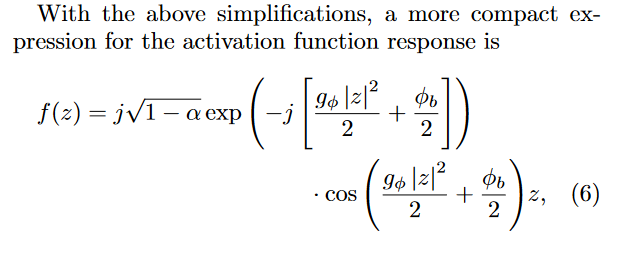

In [11]:
class EOIntensityModulation(tf.keras.layers.Layer):
    def __init__(self, N, alpha=0.1, g=np.pi, phi_b=np.pi, train_alpha=False, train_g=False, train_phi_b=False, single_param_per_layer=True):
        
        super(EOIntensityModulation, self).__init__()
        
        if single_param_per_layer:
            var_shape = [1]
        else:
            var_shape = [N]
        
        self.g = self.add_variable(shape=var_shape,
                                       name="g",
                                       initializer=tf.constant_initializer(g),
                                       trainable=train_g,
                                       constraint=lambda x: tf.clip_by_value(x, 1e-3, 1.5*np.pi))
        self.phi_b = self.add_variable(shape=var_shape,
                                       name="phi_b",
                                       initializer=tf.constant_initializer(phi_b),
                                       trainable=train_phi_b,
                                       constraint=lambda x: tf.clip_by_value(x, -np.pi, +np.pi))
        self.alpha = self.add_variable(shape=var_shape,
                                       name="alpha",
                                       initializer=tf.constant_initializer(alpha),
                                       trainable=train_alpha,
                                       constraint=lambda x: tf.clip_by_value(x, 0.01, 0.99))
    
    def call(self, inputs):
        alpha, g, phi_b = tf.complex(self.alpha, 0.0), tf.complex(self.g, 0.0), tf.complex(self.phi_b, 0.0)
        Z = inputs
        return 1j * tf.sqrt(1-alpha) * tf.exp(-1j*0.5*g*tf.math.conj(Z)*Z - 1j*0.5*phi_b) * tf.cos(0.5*g*tf.math.conj(Z)*Z + 0.5*phi_b) * Z

The procedure is summarised well by the following diagram.

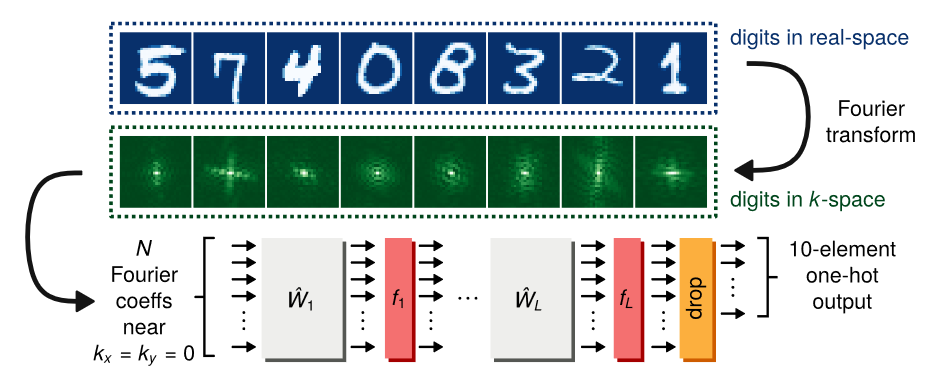

To get a better idea of the network layers -

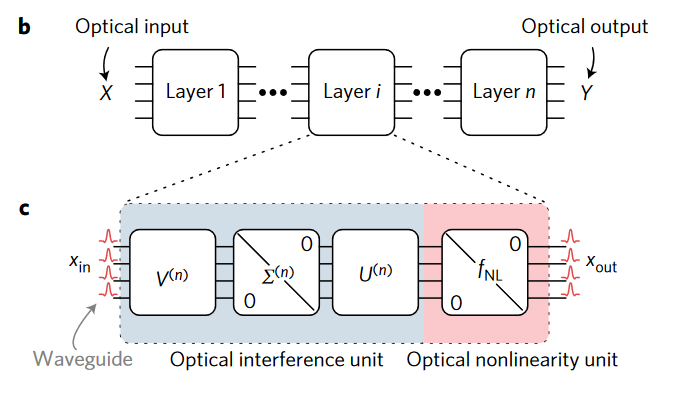

In [12]:
def generate_network(N, N_classes=10, L=1, theta_init_name='haar_rect', phi_init_name='random_phi', alpha=0.1, g=0.05*np.pi, phi_b=1*np.pi):
    """ Creates L layer ONN

    Args:
        N (int): Size of the input layer
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.
        theta_init_name (str, optional): _description_. Defaults to 'haar_rect'.
        phi_init_name (str, optional): _description_. Defaults to 'random_phi'.

    Returns:
        Sequential: _description_
    """
    layers=[]
    
    for _ in range(0, L):
        layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
        layers.append(EOIntensityModulation(N, alpha, g, phi_b))
    
    layers.append(Activation(cnorm))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    
    return Sequential(layers)

In [13]:
epochs = 100
batch_size = 512
N_classes = 10

onn_model = generate_network(144, L=2)
onn_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Aniket Kukreti\AppData\Local\Temp\ipykernel_6328\2341870276.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.g = self.add_variable(shape=var_shape,
C:\Users\Aniket Kukreti\AppData\Local\Temp\ipykernel_6328\2341870276.py:16: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.phi_b = self.add_variable(shape=var_shape,
C:\Users\Aniket Kukreti\AppData\Local\Temp\ipykernel_6328\2341870276.py:21: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.alpha = self.add_variable(shape=var_shape,


In [14]:
history = onn_model.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/100
118/118 - 276s - loss: 1.4821 - accuracy: 0.6530 - val_loss: 1.2239 - val_accuracy: 0.7685 - 276s/epoch - 2s/step
Epoch 2/100
118/118 - 100s - loss: 1.1661 - accuracy: 0.7776 - val_loss: 1.0981 - val_accuracy: 0.8002 - 100s/epoch - 846ms/step
Epoch 3/100
118/118 - 103s - loss: 1.0492 - accuracy: 0.8037 - val_loss: 0.9938 - val_accuracy: 0.8215 - 103s/epoch - 872ms/step
Epoch 4/100
118/118 - 98s - loss: 0.9689 - accuracy: 0.8183 - val_loss: 0.9306 - val_accuracy: 0.8325 - 98s/epoch - 833ms/step
Epoch 5/100
118/118 - 99s - loss: 0.9079 - accuracy: 0.8267 - val_loss: 0.8772 - val_accuracy: 0.8398 - 99s/epoch - 839ms/step
Epoch 6/100
118/118 - 100s - loss: 0.8652 - accuracy: 0.8316 - val_loss: 0.8880 - val_accuracy: 0.8375 - 100s/epoch - 846ms/step
Epoch 7/100
118/118 - 98s - loss: 0.8423 - accuracy: 0.8337 - val_loss: 0.8107 - val_accuracy: 0.8449 - 98s/epoch - 833ms/step
Epoch 8/100
118/118 - 104s - loss: 0.8008 - accuracy: 0.8383 - val_loss: 0.7692 - val_accuracy: 0.8513 - 1

| Input Dim (N) | No. of Mesh Layers (L) | Epochs | Test Acc |
|:-------------:|:----------------------:|:------:|:--------:|
|       36      |            2           |   100  |    79    |
|       64      |            2           |   100  |  84.709% |
|      100      |            2           |   100  |    86    |
|      144      |            2           |   100  |          |

-----------------------------------------------------
### Playing around with mesh layers

In [ ]:
tf_layer = RM(8) # Implicitly sets the number of MZI 'layers' to N when not specified.

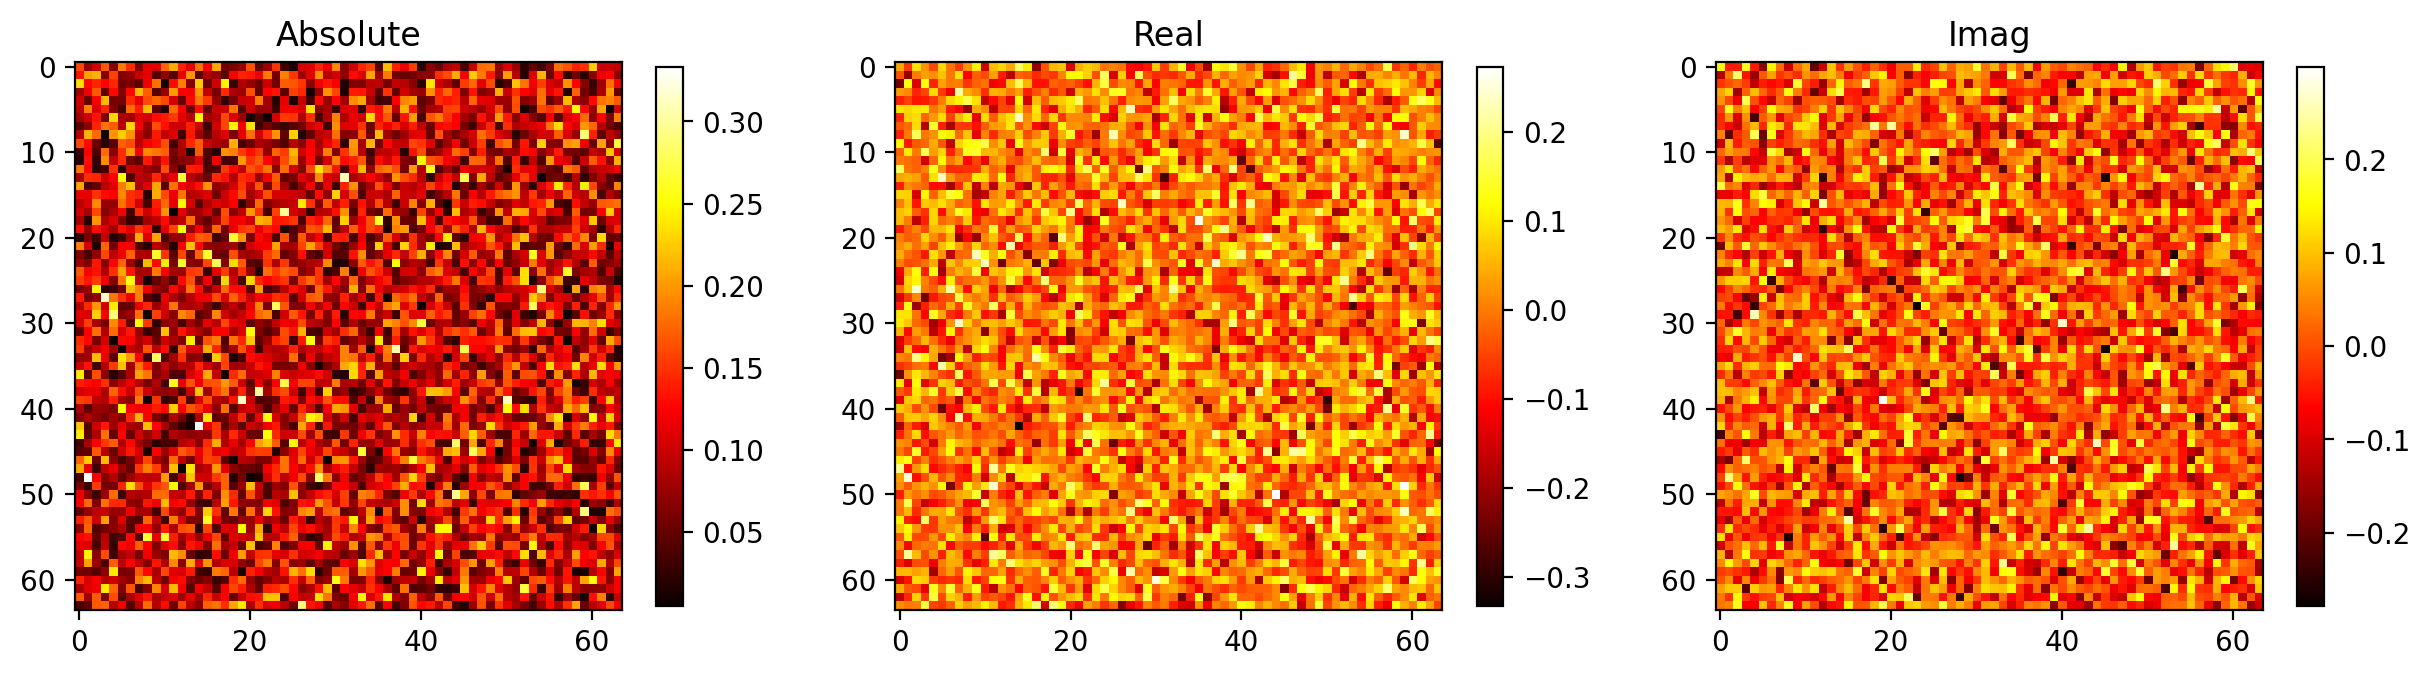

In [ ]:
tf_layer.plot(plt)